## 🚜 Predicting the Sale Price of Bulldozers using Machine Learning
In this notebook, we're going to go through an example machine learning project with the goal of predicting the sale price of bulldozers.

### 1. Problem defition
How well can we predict the future sale price of a bulldozer, given its characteristics and previous examples of how much similar bulldozers have been sold for?

### 2. Data
The data is downloaded from the Kaggle Bluebook for Bulldozers competition: https://www.kaggle.com/c/bluebook-for-bulldozers/data

There are 3 main datasets:

* Train.csv is the training set, which contains data through the end of 2011.
* Valid.csv is the validation set, which contains data from January 1, 2012 - April 30, 2012 You make predictions on this set throughout the majority of the competition. Your score on this set is used to create the public leaderboard.
* Test.csv is the test set, which won't be released until the last week of the competition. It contains data from May 1, 2012 - November 2012. Your score on the test set determines your final rank for the competition.

### 3. Evaluation
The evaluation metric for this competition is the RMSLE (root mean squared log error) between the actual and predicted auction prices.

For more on the evaluation of this project check: https://www.kaggle.com/c/bluebook-for-bulldozers/overview/evaluation

Note: The goal for most regression evaluation metrics is to minimize the error. For example, our goal for this project will be to build a machine learning model which minimises RMSLE.

### 4. Features
Kaggle provides a data dictionary detailing all of the features of the dataset. You can view this data dictionary on Google Sheets: https://docs.google.com/spreadsheets/d/18ly-bLR8sbDJLITkWG7ozKm8l3RyieQ2Fpgix-beSYI/edit?usp=sharing

In [1]:
import numpy as np

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from zipfile import ZipFile

In [3]:
# Import training and validation sets
df = pd.read_csv("TrainAndValid.csv",
                low_memory=False)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   412698 non-null  int64  
 1   SalePrice                 412698 non-null  float64
 2   MachineID                 412698 non-null  int64  
 3   ModelID                   412698 non-null  int64  
 4   datasource                412698 non-null  int64  
 5   auctioneerID              392562 non-null  float64
 6   YearMade                  412698 non-null  int64  
 7   MachineHoursCurrentMeter  147504 non-null  float64
 8   UsageBand                 73670 non-null   object 
 9   saledate                  412698 non-null  object 
 10  fiModelDesc               412698 non-null  object 
 11  fiBaseModel               412698 non-null  object 
 12  fiSecondaryDesc           271971 non-null  object 
 13  fiModelSeries             58667 non-null   o

In [5]:
df.isna().sum()

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
UsageBand                   339028
saledate                         0
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             140727
fiModelSeries               354031
fiModelDescriptor           337882
ProductSize                 216605
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                305611
Enclosure                      334
Forks                       214983
Pad_Type                    331602
Ride_Control                259970
Stick                       331602
Transmission                224691
Turbocharged                331602
Blade_Extension     

In [6]:
df.columns

Index(['SalesID', 'SalePrice', 'MachineID', 'ModelID', 'datasource',
       'auctioneerID', 'YearMade', 'MachineHoursCurrentMeter', 'UsageBand',
       'saledate', 'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc',
       'fiModelSeries', 'fiModelDescriptor', 'ProductSize',
       'fiProductClassDesc', 'state', 'ProductGroup', 'ProductGroupDesc',
       'Drive_System', 'Enclosure', 'Forks', 'Pad_Type', 'Ride_Control',
       'Stick', 'Transmission', 'Turbocharged', 'Blade_Extension',
       'Blade_Width', 'Enclosure_Type', 'Engine_Horsepower', 'Hydraulics',
       'Pushblock', 'Ripper', 'Scarifier', 'Tip_Control', 'Tire_Size',
       'Coupler', 'Coupler_System', 'Grouser_Tracks', 'Hydraulics_Flow',
       'Track_Type', 'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb',
       'Pattern_Changer', 'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type',
       'Travel_Controls', 'Differential_Type', 'Steering_Controls'],
      dtype='object')

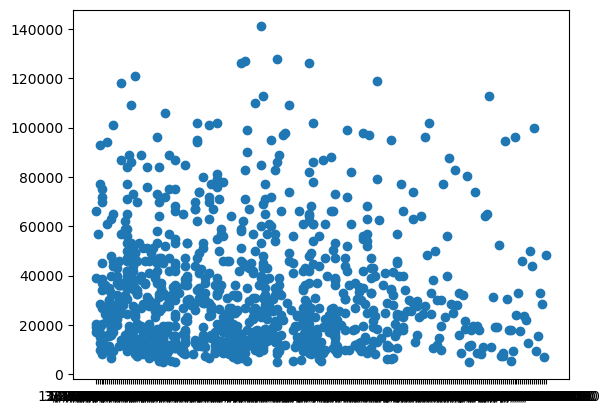

In [7]:
fig, ax = plt.subplots()
ax.scatter(df["saledate"][:1000], df["SalePrice"][:1000]);

In [8]:
df.saledate[:1000]

0      11/16/2006 0:00
1       3/26/2004 0:00
2       2/26/2004 0:00
3       5/19/2011 0:00
4       7/23/2009 0:00
            ...       
995     7/16/2009 0:00
996     6/14/2007 0:00
997     9/22/2005 0:00
998     7/28/2005 0:00
999     6/16/2011 0:00
Name: saledate, Length: 1000, dtype: object

In [9]:
df.saledate.dtype

dtype('O')

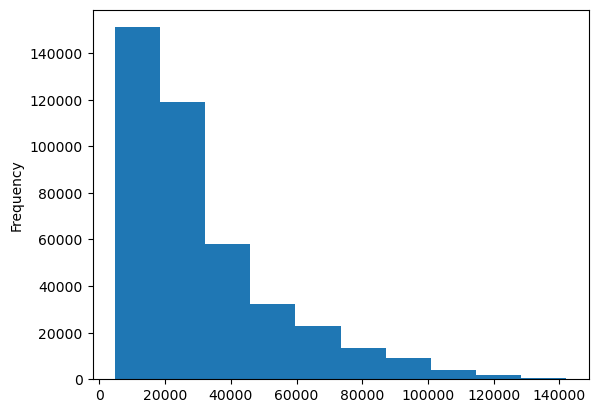

In [10]:
df.SalePrice.plot.hist();

### Parsing dates
When we work with time series data, we want to enrich the time & date component as much as possible.

We can do that by telling pandas which of our columns has dates in it using the parse_dates parameter.

In [11]:
# Import data again but this time parse dates
df = pd.read_csv("TrainAndValid.csv",
                 low_memory=False,
                 parse_dates=["saledate"])

In [12]:
df.saledate.dtype

dtype('<M8[ns]')

In [13]:
df.saledate[:1000]

0     2006-11-16
1     2004-03-26
2     2004-02-26
3     2011-05-19
4     2009-07-23
         ...    
995   2009-07-16
996   2007-06-14
997   2005-09-22
998   2005-07-28
999   2011-06-16
Name: saledate, Length: 1000, dtype: datetime64[ns]

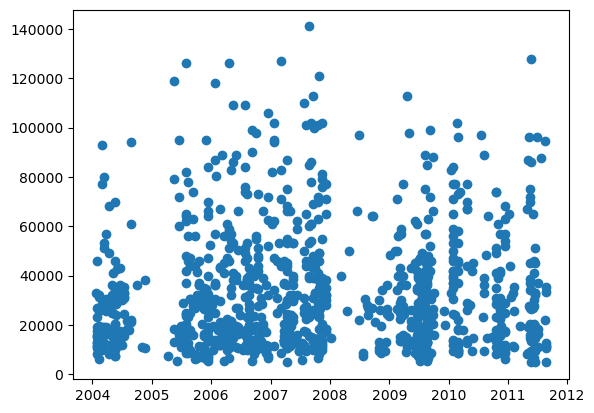

In [14]:
fig, ax = plt.subplots()
ax.scatter(df["saledate"][:1000], df["SalePrice"][:1000]);

In [15]:
df.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,66000.0,999089,3157,121,3.0,2004,68.0,Low,2006-11-16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
1,1139248,57000.0,117657,77,121,3.0,1996,4640.0,Low,2004-03-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1139249,10000.0,434808,7009,121,3.0,2001,2838.0,High,2004-02-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1139251,38500.0,1026470,332,121,3.0,2001,3486.0,High,2011-05-19,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1139253,11000.0,1057373,17311,121,3.0,2007,722.0,Medium,2009-07-23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
df.head().T

,0,1,2,3,4
SalesID,1139246,1139248,1139249,1139251,1139253
SalePrice,66000.0,57000.0,10000.0,38500.0,11000.0
MachineID,999089,117657,434808,1026470,1057373
ModelID,3157,77,7009,332,17311
datasource,121,121,121,121,121
auctioneerID,3.0,3.0,3.0,3.0,3.0
YearMade,2004,1996,2001,2001,2007
MachineHoursCurrentMeter,68.0,4640.0,2838.0,3486.0,722.0
UsageBand,Low,Low,High,High,Medium
saledate,2006-11-16 00:00:00,2004-03-26 00:00:00,2004-02-26 00:00:00,2011-05-19 00:00:00,2009-07-23 00:00:00


In [17]:
df.saledate.head(20)

0    2006-11-16
1    2004-03-26
2    2004-02-26
3    2011-05-19
4    2009-07-23
5    2008-12-18
6    2004-08-26
7    2005-11-17
8    2009-08-27
9    2007-08-09
10   2008-08-21
11   2006-08-24
12   2005-10-20
13   2006-01-26
14   2006-01-03
15   2006-11-16
16   2007-06-14
17   2010-01-28
18   2006-03-09
19   2005-11-17
Name: saledate, dtype: datetime64[ns]

## Sort DataFrame by saledate
When working with time series data, it's a good idea to sort it by date.

In [18]:
# Sort DataFrame in date order
df.sort_values(by=["saledate"], inplace=True, ascending=True)
df.saledate.head(20)

205615   1989-01-17
274835   1989-01-31
141296   1989-01-31
212552   1989-01-31
62755    1989-01-31
54653    1989-01-31
81383    1989-01-31
204924   1989-01-31
135376   1989-01-31
113390   1989-01-31
113394   1989-01-31
116419   1989-01-31
32138    1989-01-31
127610   1989-01-31
76171    1989-01-31
127000   1989-01-31
128130   1989-01-31
127626   1989-01-31
55455    1989-01-31
55454    1989-01-31
Name: saledate, dtype: datetime64[ns]

## Make a copy of the original DataFrame
We make a copy of the original dataframe so when we manipulate the copy, we've still got our original data.

In [19]:
# Make a copy of the original DataFrame to perform edits on
df_tmp = df.copy()

### Add datetime parameters for saledate column

In [20]:
# Add datetime parameters for saledate
df_tmp["saleYear"] = df_tmp.saledate.dt.year
df_tmp["saleMonth"] = df_tmp.saledate.dt.month
df_tmp["saleDay"] = df_tmp.saledate.dt.day
df_tmp["saleDayofweek"] = df_tmp.saledate.dt.dayofweek
df_tmp["saleDayofyear"] = df_tmp.saledate.dt.dayofyear

# Drop original saledate
df_tmp.drop("saledate", axis=1, inplace=True)

In [21]:
df_tmp.head().T

,205615,274835,141296,212552,62755
SalesID,1646770,1821514,1505138,1671174,1329056
SalePrice,9500.0,14000.0,50000.0,16000.0,22000.0
MachineID,1126363,1194089,1473654,1327630,1336053
ModelID,8434,10150,4139,8591,4089
datasource,132,132,132,132,132
auctioneerID,18.0,99.0,99.0,99.0,99.0
YearMade,1974,1980,1978,1980,1984
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN
fiModelDesc,TD20,A66,D7G,A62,D3B


In [22]:
# Check the different values of different columns
df_tmp.state.value_counts()

state
Florida           67320
Texas             53110
California        29761
Washington        16222
Georgia           14633
Maryland          13322
Mississippi       13240
Ohio              12369
Illinois          11540
Colorado          11529
New Jersey        11156
North Carolina    10636
Tennessee         10298
Alabama           10292
Pennsylvania      10234
South Carolina     9951
Arizona            9364
New York           8639
Connecticut        8276
Minnesota          7885
Missouri           7178
Nevada             6932
Louisiana          6627
Kentucky           5351
Maine              5096
Indiana            4124
Arkansas           3933
New Mexico         3631
Utah               3046
Unspecified        2801
Wisconsin          2745
New Hampshire      2738
Virginia           2353
Idaho              2025
Oregon             1911
Michigan           1831
Wyoming            1672
Montana            1336
Iowa               1336
Oklahoma           1326
Nebraska            866
West Virgi

In [23]:
# Check the values of different columns
df_tmp.state.value_counts()

state
Florida           67320
Texas             53110
California        29761
Washington        16222
Georgia           14633
Maryland          13322
Mississippi       13240
Ohio              12369
Illinois          11540
Colorado          11529
New Jersey        11156
North Carolina    10636
Tennessee         10298
Alabama           10292
Pennsylvania      10234
South Carolina     9951
Arizona            9364
New York           8639
Connecticut        8276
Minnesota          7885
Missouri           7178
Nevada             6932
Louisiana          6627
Kentucky           5351
Maine              5096
Indiana            4124
Arkansas           3933
New Mexico         3631
Utah               3046
Unspecified        2801
Wisconsin          2745
New Hampshire      2738
Virginia           2353
Idaho              2025
Oregon             1911
Michigan           1831
Wyoming            1672
Montana            1336
Iowa               1336
Oklahoma           1326
Nebraska            866
West Virgi

In [24]:
df_tmp.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleYear,saleMonth,saleDay,saleDayofweek,saleDayofyear
205615,1646770,9500.0,1126363,8434,132,18.0,1974,NaN,NaN,TD20,...,None or Unspecified,Straight,None or Unspecified,NaN,NaN,1989,1,17,1,17
274835,1821514,14000.0,1194089,10150,132,99.0,1980,NaN,NaN,A66,...,NaN,NaN,NaN,Standard,Conventional,1989,1,31,1,31
141296,1505138,50000.0,1473654,4139,132,99.0,1978,NaN,NaN,D7G,...,None or Unspecified,Straight,None or Unspecified,NaN,NaN,1989,1,31,1,31
212552,1671174,16000.0,1327630,8591,132,99.0,1980,NaN,NaN,A62,...,NaN,NaN,NaN,Standard,Conventional,1989,1,31,1,31
62755,1329056,22000.0,1336053,4089,132,99.0,1984,NaN,NaN,D3B,...,None or Unspecified,PAT,Lever,NaN,NaN,1989,1,31,1,31


In [25]:
len(df_tmp)

412698

## 5. Modelling
We've explored our dataset a little as well as enriched it with some datetime attributes, now let's try to model.

Why model so early?

We know the evaluation metric we're heading towards. We could spend more time doing exploratory data analysis (EDA), finding more out about the data ourselves but what we'll do instead is use a machine learning model to help us do EDA.

Remember, one of the biggest goals of starting any new machine learning project is reducing the time between experiments.

Following the Scikit-Learn machine learning map, we find a RandomForestRegressor() might be a good candidate.

In [26]:
# This won't work since we've got missing numbers and categories
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_jobs=-1)
model.fit(df_tmp.drop("SalePrice", axis=1), df_tmp.SalePrice)

ValueError: could not convert string to float: 'Low'

In [27]:
# Check for missing categories and different datatypes
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 412698 entries, 205615 to 409203
Data columns (total 57 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   412698 non-null  int64  
 1   SalePrice                 412698 non-null  float64
 2   MachineID                 412698 non-null  int64  
 3   ModelID                   412698 non-null  int64  
 4   datasource                412698 non-null  int64  
 5   auctioneerID              392562 non-null  float64
 6   YearMade                  412698 non-null  int64  
 7   MachineHoursCurrentMeter  147504 non-null  float64
 8   UsageBand                 73670 non-null   object 
 9   fiModelDesc               412698 non-null  object 
 10  fiBaseModel               412698 non-null  object 
 11  fiSecondaryDesc           271971 non-null  object 
 12  fiModelSeries             58667 non-null   object 
 13  fiModelDescriptor         74816 non-null   o

In [28]:
# Check for missing values
df_tmp.isna().sum()

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
UsageBand                   339028
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             140727
fiModelSeries               354031
fiModelDescriptor           337882
ProductSize                 216605
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                305611
Enclosure                      334
Forks                       214983
Pad_Type                    331602
Ride_Control                259970
Stick                       331602
Transmission                224691
Turbocharged                331602
Blade_Extension             386715
Blade_Width         

In [29]:
df_tmp.isna().sum()# we have to fix this null values 

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
UsageBand                   339028
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             140727
fiModelSeries               354031
fiModelDescriptor           337882
ProductSize                 216605
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                305611
Enclosure                      334
Forks                       214983
Pad_Type                    331602
Ride_Control                259970
Stick                       331602
Transmission                224691
Turbocharged                331602
Blade_Extension             386715
Blade_Width         

### Convert string to categories
One way we can turn all of our data into numbers is by converting them into pandas catgories.

We can check the different datatypes compatible with pandas here: https://pandas.pydata.org/pandas-docs/stable/reference/general_utility_functions.html#data-types-related-functionality - old version.

NEW VERSION : One way to help turn all of our data into numbers is to convert the columns with the string datatype into a category datatype.

To do this we can use the pandas types API which allows us to interact and manipulate the types of dat





In [30]:
df_tmp.head().T

,205615,274835,141296,212552,62755
SalesID,1646770,1821514,1505138,1671174,1329056
SalePrice,9500.0,14000.0,50000.0,16000.0,22000.0
MachineID,1126363,1194089,1473654,1327630,1336053
ModelID,8434,10150,4139,8591,4089
datasource,132,132,132,132,132
auctioneerID,18.0,99.0,99.0,99.0,99.0
YearMade,1974,1980,1978,1980,1984
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN
fiModelDesc,TD20,A66,D7G,A62,D3B


In [31]:
pd.api.types.is_string_dtype(df_tmp["UsageBand"])

False

In [32]:
# These columns contain strings
for label, content in df_tmp.items():
    if pd.api.types.is_string_dtype(content):
        print(label)

fiModelDesc
fiBaseModel
fiProductClassDesc
state
ProductGroup
ProductGroupDesc


In [33]:
# If you're wondering what df.items() does, let's use a dictionary as an example
random_dict = {"key1": "hello",
               "key2": "world!"}

for key, value in random_dict.items():
    print(f"This is a key: {key}")
    print(f"This is a value: {value}")

This is a key: key1
This is a value: hello
This is a key: key2
This is a value: world!


In [34]:
# This will turn all of the string values into category values
for label, content in df_tmp.items():
    if pd.api.types.is_string_dtype(content):
        df_tmp[label] = content.astype("category").cat.as_ordered()

In [35]:
df_tmp.info() # changed object to categories but did not diaplayed on chart

<class 'pandas.core.frame.DataFrame'>
Index: 412698 entries, 205615 to 409203
Data columns (total 57 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   SalesID                   412698 non-null  int64   
 1   SalePrice                 412698 non-null  float64 
 2   MachineID                 412698 non-null  int64   
 3   ModelID                   412698 non-null  int64   
 4   datasource                412698 non-null  int64   
 5   auctioneerID              392562 non-null  float64 
 6   YearMade                  412698 non-null  int64   
 7   MachineHoursCurrentMeter  147504 non-null  float64 
 8   UsageBand                 73670 non-null   object  
 9   fiModelDesc               412698 non-null  category
 10  fiBaseModel               412698 non-null  category
 11  fiSecondaryDesc           271971 non-null  object  
 12  fiModelSeries             58667 non-null   object  
 13  fiModelDescriptor         748

In [36]:
df_tmp.state.cat.categories

Index(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado',
       'Connecticut', 'Delaware', 'Florida', 'Georgia', 'Hawaii', 'Idaho',
       'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana',
       'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota',
       'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada',
       'New Hampshire', 'New Jersey', 'New Mexico', 'New York',
       'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon',
       'Pennsylvania', 'Puerto Rico', 'Rhode Island', 'South Carolina',
       'South Dakota', 'Tennessee', 'Texas', 'Unspecified', 'Utah', 'Vermont',
       'Virginia', 'Washington', 'Washington DC', 'West Virginia', 'Wisconsin',
       'Wyoming'],
      dtype='object')

In [39]:
df_tmp.state.cat.codes

205615    43
274835     8
141296     8
212552     8
62755      8
          ..
410879     4
412476     4
411927     4
407124     4
409203     4
Length: 412698, dtype: int8

Thanks to pandas Categories we now have a way to access all of our data in the form of numbers.

But we still have a bunch of missing data...

In [42]:
df_tmp.isnull().sum()/len(df_tmp) #check missing values

SalesID                     0.000000
SalePrice                   0.000000
MachineID                   0.000000
ModelID                     0.000000
datasource                  0.000000
auctioneerID                0.048791
YearMade                    0.000000
MachineHoursCurrentMeter    0.642586
UsageBand                   0.821492
fiModelDesc                 0.000000
fiBaseModel                 0.000000
fiSecondaryDesc             0.340993
fiModelSeries               0.857845
fiModelDescriptor           0.818715
ProductSize                 0.524851
fiProductClassDesc          0.000000
state                       0.000000
ProductGroup                0.000000
ProductGroupDesc            0.000000
Drive_System                0.740520
Enclosure                   0.000809
Forks                       0.520921
Pad_Type                    0.803498
Ride_Control                0.629928
Stick                       0.803498
Transmission                0.544444
Turbocharged                0.803498
B

## Save preprocessed data

In [45]:
# Export current tmp dataframe
df_tmp.to_csv("train_tmp.csv",
              index=False)

In [46]:
# Import preprocessed data
df_tmp = pd.read_csv("train_tmp.csv",
                     low_memory=False)
df_tmp.head().T

,0,1,2,3,4
SalesID,1646770,1821514,1505138,1671174,1329056
SalePrice,9500.0,14000.0,50000.0,16000.0,22000.0
MachineID,1126363,1194089,1473654,1327630,1336053
ModelID,8434,10150,4139,8591,4089
datasource,132,132,132,132,132
auctioneerID,18.0,99.0,99.0,99.0,99.0
YearMade,1974,1980,1978,1980,1984
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN
fiModelDesc,TD20,A66,D7G,A62,D3B


In [47]:
df_tmp.isna().sum()

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
UsageBand                   339028
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             140727
fiModelSeries               354031
fiModelDescriptor           337882
ProductSize                 216605
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                305611
Enclosure                      334
Forks                       214983
Pad_Type                    331602
Ride_Control                259970
Stick                       331602
Transmission                224691
Turbocharged                331602
Blade_Extension             386715
Blade_Width         

## Fill missing values
From our experience with machine learning models. We know two things:
1. 
All of our data has to be numerica2. l
There can't be any missing values
And as we've seen using df_tmp.isna().sum() our data still has plenty of missing values.

Let's fill them.
### Fill numerical missing values
We're going to fill any column with missing values with the median of that column. first

In [48]:
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        print(label)

SalesID
SalePrice
MachineID
ModelID
datasource
auctioneerID
YearMade
MachineHoursCurrentMeter
saleYear
saleMonth
saleDay
saleDayofweek
saleDayofyear


In [49]:
# Check for which numeric columns have null values
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            print(label)

auctioneerID
MachineHoursCurrentMeter


In [50]:
# Fill numeric rows with the median
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            # Add a binary column which tells if the data was missing our not
            df_tmp[label+"_is_missing"] = pd.isnull(content)
            # Fill missing numeric values with median since it's more robust than the mean
            df_tmp[label] = content.fillna(content.median())

Why add a binary column indicating whether the data was missing or not?

We can easily fill all of the missing numeric values in our dataset with the median. However, a numeric value may be missing for a reason. In other words, absence of evidence may be evidence of absence. Adding a binary column which indicates whether the value was missing or not helps to retain this information.

In [51]:
# Check if there's any null values
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            print(label)

In [52]:
# Check to see how many examples were missing
df_tmp.auctioneerID_is_missing.value_counts()

auctioneerID_is_missing
False    392562
True      20136
Name: count, dtype: int64

## Filling and turning categorical variables to numbers
Now we've filled the numeric values, we'll do the same with the categorical values at the same time as turning them into numbers.

In [53]:
# Check columns which *aren't* numeric
for label, content in df_tmp.items():
    if not pd.api.types.is_numeric_dtype(content):
        print(label)

UsageBand
fiModelDesc
fiBaseModel
fiSecondaryDesc
fiModelSeries
fiModelDescriptor
ProductSize
fiProductClassDesc
state
ProductGroup
ProductGroupDesc
Drive_System
Enclosure
Forks
Pad_Type
Ride_Control
Stick
Transmission
Turbocharged
Blade_Extension
Blade_Width
Enclosure_Type
Engine_Horsepower
Hydraulics
Pushblock
Ripper
Scarifier
Tip_Control
Tire_Size
Coupler
Coupler_System
Grouser_Tracks
Hydraulics_Flow
Track_Type
Undercarriage_Pad_Width
Stick_Length
Thumb
Pattern_Changer
Grouser_Type
Backhoe_Mounting
Blade_Type
Travel_Controls
Differential_Type
Steering_Controls


In [54]:
# Turn categorical variables into numbers
for label, content in df_tmp.items():
    # Check columns which *aren't* numeric
    if not pd.api.types.is_numeric_dtype(content):
        # Add binary column to inidicate whether sample had missing value
        df_tmp[label+"_is_missing"] = pd.isnull(content)
        # We add the +1 because pandas encodes missing categories as -1
        df_tmp[label] = pd.Categorical(content).codes+1 

In [55]:
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Columns: 103 entries, SalesID to Steering_Controls_is_missing
dtypes: bool(46), float64(3), int16(4), int64(10), int8(40)
memory usage: 77.9 MB


In [56]:
df_tmp.isna().sum()

SalesID                         0
SalePrice                       0
MachineID                       0
ModelID                         0
datasource                      0
                               ..
Backhoe_Mounting_is_missing     0
Blade_Type_is_missing           0
Travel_Controls_is_missing      0
Differential_Type_is_missing    0
Steering_Controls_is_missing    0
Length: 103, dtype: int64

In [57]:
df_tmp.head().T

,0,1,2,3,4
SalesID,1646770,1821514,1505138,1671174,1329056
SalePrice,9500.0,14000.0,50000.0,16000.0,22000.0
MachineID,1126363,1194089,1473654,1327630,1336053
ModelID,8434,10150,4139,8591,4089
datasource,132,132,132,132,132
...,...,...,...,...,...
Backhoe_Mounting_is_missing,False,True,False,True,False
Blade_Type_is_missing,False,True,False,True,False
Travel_Controls_is_missing,False,True,False,True,False
Differential_Type_is_missing,True,False,True,False,True


Now all of our data is numeric and there are no missing values, we should be able to build a machine learning model!

Let's reinstantiate our trusty RandomForestRegressor.

This will take a few minutes which is too long for interacting with it. So what we'll do is create a subset of rows to work with.

In [58]:
%%time
# Instantiate model
model = RandomForestRegressor(n_jobs=-1)

# Fit the model
model.fit(df_tmp.drop("SalePrice", axis=1), df_tmp.SalePrice)

CPU times: total: 32min 16s
Wall time: 2min 17s


RandomForestRegressor(n_jobs=-1)

In [59]:
# Score the model
model.score(df_tmp.drop("SalePrice", axis=1), df_tmp.SalePrice)

0.9875567041676686

**Question**: Why is this metric not reliable?

Question: Why doesn't the above metric hold water? (why isn't the metric reliable)

## Splitting data into train/validation sets

In [61]:
df_tmp.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,Undercarriage_Pad_Width_is_missing,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing
0,1646770,9500.0,1126363,8434,132,18.0,1974,0.0,0,4593,...,True,True,True,True,True,False,False,False,True,True
1,1821514,14000.0,1194089,10150,132,99.0,1980,0.0,0,1820,...,True,True,True,True,True,True,True,True,False,False
2,1505138,50000.0,1473654,4139,132,99.0,1978,0.0,0,2348,...,True,True,True,True,True,False,False,False,True,True
3,1671174,16000.0,1327630,8591,132,99.0,1980,0.0,0,1819,...,True,True,True,True,True,True,True,True,False,False
4,1329056,22000.0,1336053,4089,132,99.0,1984,0.0,0,2119,...,True,True,True,True,True,False,False,False,True,True


According to the Kaggle data page, the validation set and test set are split according to dates.

This makes sense since we're working on a time series problem.

E.g. using past events to try and predict future events.

Knowing this, randomly splitting our data into train and test sets using something like train_test_split() wouldn't work.

Instead, we split our data into training, validation and test sets using the date each sample occured.

In our case:

 * Training = all samples up until 2011
 * Valid = all samples form January 1, 2012 - April 30, 2012
 * Test = all samples from May 1, 2012 - November 2012

For more on making good training, validation and test sets, check out the post How (and why) to create a good validation set by Rachel Thomas.

In [63]:
df_tmp.saleYear.value_counts()

saleYear
2009    43849
2008    39767
2011    35197
2010    33390
2007    32208
2006    21685
2005    20463
2004    19879
2001    17594
2000    17415
2002    17246
2003    15254
1998    13046
1999    12793
2012    11573
1997     9785
1996     8829
1995     8530
1994     7929
1993     6303
1992     5519
1991     5109
1989     4806
1990     4529
Name: count, dtype: int64

In [64]:
# Split data into training and validation
df_val = df_tmp[df_tmp.saleYear == 2012]
df_train = df_tmp[df_tmp.saleYear != 2012]

len(df_val), len(df_train)

(11573, 401125)

In [65]:
# Split data into X & y
X_train, y_train = df_train.drop("SalePrice", axis=1), df_train.SalePrice
X_valid, y_valid = df_val.drop("SalePrice", axis=1), df_val.SalePrice

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((401125, 102), (401125,), (11573, 102), (11573,))

### Building an evaluation function

According to Kaggle for the Bluebook for Bulldozers competition, the evaluation function they use is root mean squared log error (RMSLE).

RMSLE = generally you don't care as much if you're off by $10 as much as you'd care if you were off by 10%, you care more about ratios rather than differences. MAE (mean absolute error) is more about exact differences.

It's important to understand the evaluation metric you're going for.

Since Scikit-Learn doesn't have a function built-in for RMSLE, we'll create our own.

We can do this by taking the square root of Scikit-Learn's mean_squared_log_error (MSLE). MSLE is the same as taking the log of mean squared error (MSE).

We'll also calculate the MAE and R^2 for fun.

   return scores

In [67]:
# Create evaluation function (the competition uses Root Mean Square Log Error)
from sklearn.metrics import mean_squared_log_error, mean_absolute_error

def rmsle(y_test, y_preds):
    return np.sqrt(mean_squared_log_error(y_test, y_preds))

# Create function to evaluate our model
def show_scores(model):
    train_preds = model.predict(X_train)
    val_preds = model.predict(X_valid)
    scores = {"Training MAE": mean_absolute_error(y_train, train_preds),
              "Valid MAE": mean_absolute_error(y_valid, val_preds),
              "Training RMSLE": rmsle(y_train, train_preds),
              "Valid RMSLE": rmsle(y_valid, val_preds),
              "Training R^2": model.score(X_train, y_train),
              "Valid R^2": model.score(X_valid, y_valid)}
    return scores

## Testing our model on a subset (to tune the hyperparameters)
Retraing an entire model would take far too long to continuing experimenting as fast as we want to.

So what we'll do is take a sample of the training set and tune the hyperparameters on that before training a larger model.

If you're experiments are taking longer than 10-seconds (give or take how long you have to wait), you should be trying to speed things up. You can speed things up by sampling less data or using a faster computer.

In [ ]:
# # This takes far too long... for experimenting

# %%time
# model = RandomForestRegressor(n_jobs=-1, 
#                               random_state=42)

# model.fit(X_train, y_train)

In [68]:
len(X_train)

401125

Depending on your computer (mine is a MacBook Pro), making calculations on ~400,000 rows may take a while...

Let's alter the number of samples each n_estimator in the RandomForestRegressor see's using the max_samples parameter.

In [69]:
# Change max samples in RandomForestRegressor
model = RandomForestRegressor(n_jobs=-1,
                              max_samples=10000)

Setting max_samples to 10000 means every n_estimator (default 100) in our RandomForestRegressor will only see 10000 random samples from our DataFrame instead of the entire 400,000.

In other words, we'll be looking at 40x less samples which means we'll get faster computation speeds but we should expect our results to worsen (simple the model has less samples to learn patterns from).

In [70]:
%%time
# Cutting down the max number of samples each tree can see improves training time
model.fit(X_train, y_train)

CPU times: total: 55.6 s
Wall time: 4.43 s


RandomForestRegressor(max_samples=10000, n_jobs=-1)

In [71]:
show_scores(model)

{'Training MAE': 5554.361351972577,
 'Valid MAE': 7154.652359802989,
 'Training RMSLE': 0.25736982031940386,
 'Valid RMSLE': 0.2935119955056193,
 'Training R^2': 0.8610914588473157,
 'Valid R^2': 0.8336851204551929}

Beautiful, that took far less time than the model with all the data.

With this, let's try tune some hyperparameters.

### Hyerparameter tuning with RandomizedSearchCV
You can increase n_iter to try more combinations of hyperparameters but in our case, we'll try 20 and see where it gets us.

Remember, we're trying to reduce the amount of time it takes between experiments.

In [72]:
%%time
from sklearn.model_selection import RandomizedSearchCV

# Different RandomForestClassifier hyperparameters
rf_grid = {"n_estimators": np.arange(10, 100, 10),
           "max_depth": [None, 3, 5, 10],
           "min_samples_split": np.arange(2, 20, 2),
           "min_samples_leaf": np.arange(1, 20, 2),
           "max_features": [0.5, 1.0, "sqrt"], # Note: "max_features='auto'" is equivalent to "max_features=1.0", as of Scikit-Learn version 1.1
           "max_samples": [10000]}

rs_model = RandomizedSearchCV(RandomForestRegressor(),
                              param_distributions=rf_grid,
                              n_iter=20,
                              cv=5,
                              verbose=True)

rs_model.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
CPU times: total: 3min
Wall time: 4min 55s


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=20,
                   param_distributions={'max_depth': [None, 3, 5, 10],
                                        'max_features': [0.5, 1.0, 'sqrt'],
                                        'max_samples': [10000],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([10, 20, 30, 40, 50, 60, 70, 80, 90])},
                   verbose=True)

In [73]:
# Find the best model hyperparameters
rs_model.best_params_

{'n_estimators': 30,
 'min_samples_split': 18,
 'min_samples_leaf': 9,
 'max_samples': 10000,
 'max_features': 1.0,
 'max_depth': None}

In [74]:
# Evaluate the RandomizedSearch model
show_scores(rs_model)

{'Training MAE': 6101.041178389114,
 'Valid MAE': 7621.330256322687,
 'Training RMSLE': 0.27730094178310294,
 'Valid RMSLE': 0.3056059561298852,
 'Training R^2': 0.8309681071538335,
 'Valid R^2': 0.8019556729109266}

### Train a model with the best hyperparamters
In a model I prepared earlier, I tried 100 different combinations of hyperparameters (setting n_iter to 100 in RandomizedSearchCV) and found the best results came from the ones you see below.

Note: This kind of search on my computer (n_iter = 100) took ~2-hours. So it's kind of a set and come back later experiment.

We'll instantiate a new model with these discovered hyperparameters and reset the max_samples back to its original value.

In [75]:
%%time
# Most ideal hyperparameters
ideal_model = RandomForestRegressor(n_estimators=90,
                                    min_samples_leaf=1,
                                    min_samples_split=14,
                                    max_features=0.5,
                                    n_jobs=-1,
                                    max_samples=None)
ideal_model.fit(X_train, y_train)

CPU times: total: 14min 32s
Wall time: 1min


RandomForestRegressor(max_features=0.5, min_samples_split=14, n_estimators=90,
                      n_jobs=-1)

In [76]:
#Scores for ideal_model (trained on all the data)
show_scores(ideal_model)

{'Training MAE': 2925.9185060463874,
 'Valid MAE': 5889.031132453533,
 'Training RMSLE': 0.1432825894228388,
 'Valid RMSLE': 0.2441251773769448,
 'Training R^2': 0.9597327710971472,
 'Valid R^2': 0.8835331757543138}

With these new hyperparameters as well as using all the samples, we can see an improvement to our models performance.

You can make a faster model by altering some of the hyperparameters. Particularly by lowering n_estimators since each increase in n_estimators is basically building another small model.

However, lowering of n_estimators or altering of other hyperparameters may lead to poorer results.

In [77]:
%%time
# Faster model
fast_model = RandomForestRegressor(n_estimators=40,
                                   min_samples_leaf=3,
                                   max_features=0.5,
                                   n_jobs=-1)
fast_model.fit(X_train, y_train)

CPU times: total: 5min 46s
Wall time: 29.1 s


RandomForestRegressor(max_features=0.5, min_samples_leaf=3, n_estimators=40,
                      n_jobs=-1)

In [78]:
show_scores(fast_model)

{'Training MAE': 2540.269299321305,
 'Valid MAE': 5900.173525753856,
 'Training RMSLE': 0.1292708137752796,
 'Valid RMSLE': 0.24323552861244044,
 'Training R^2': 0.9672553164853737,
 'Valid R^2': 0.8822618865629903}

## Make predictions on test data

Make predictions on test data
Now we've got a trained model, it's time to make predictions on the test data.

Remember what we've done.

Our model is trained on data prior to 2011. However, the test data is from May 1 2012 to November 2012.

So what we're doing is trying to use the patterns our model has learned in the training data to predict the sale price of a Bulldozer with characteristics it's never seen before but are assumed to be similar to that of those in the training data.

In [80]:
df_test = pd.read_csv("Test.csv",
                      parse_dates=["saledate"])
df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,fiModelDesc,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1227829,1006309,3168,121,3,1999,3688.0,Low,2012-05-03,580G,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1227844,1022817,7271,121,3,1000,28555.0,High,2012-05-10,936,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1227847,1031560,22805,121,3,2004,6038.0,Medium,2012-05-10,EC210BLC,...,None or Unspecified,"9' 6""",Manual,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
3,1227848,56204,1269,121,3,2006,8940.0,High,2012-05-10,330CL,...,None or Unspecified,None or Unspecified,Manual,Yes,Triple,NaN,NaN,NaN,NaN,NaN
4,1227863,1053887,22312,121,3,2005,2286.0,Low,2012-05-10,650K,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,PAT,None or Unspecified,NaN,NaN


In [81]:
# Let's see how the model goes predicting on the test data
model.predict(df_test)

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- saledate
Feature names seen at fit time, yet now missing:
- Backhoe_Mounting_is_missing
- Blade_Extension_is_missing
- Blade_Type_is_missing
- Blade_Width_is_missing
- Coupler_System_is_missing
- ...


Ahhh... the test data isn't in the same format of our other data, so we have to fix it. Let's create a function to preprocess our data.

### Preprocessing the data (getting the test dataset in the same format as our training dataset)

Our model has been trained on data formatted in the same way as the training data.

This means in order to make predictions on the test data, we need to take the same steps we used to preprocess the training data to preprocess the test data.

Remember: Whatever you do to the training data, you have to do to the test data.

Let's create a function for doing so (by copying the preprocessing steps we used above).

In [82]:
def preprocess_data(df):
    # Add datetime parameters for saledate
    df["saleYear"] = df.saledate.dt.year
    df["saleMonth"] = df.saledate.dt.month
    df["saleDay"] = df.saledate.dt.day
    df["saleDayofweek"] = df.saledate.dt.dayofweek
    df["saleDayofyear"] = df.saledate.dt.dayofyear

    # Drop original saledate
    df.drop("saledate", axis=1, inplace=True)
    
    # Fill numeric rows with the median
    for label, content in df.items():
        if pd.api.types.is_numeric_dtype(content):
            if pd.isnull(content).sum():
                df[label+"_is_missing"] = pd.isnull(content)
                df[label] = content.fillna(content.median())
                
        # Turn categorical variables into numbers
        if not pd.api.types.is_numeric_dtype(content):
            df[label+"_is_missing"] = pd.isnull(content)
            # We add the +1 because pandas encodes missing categories as -1
            df[label] = pd.Categorical(content).codes+1        
    
    return df

Question: Where would this function break?

Hint: What if the test data had different missing values to the training data?

Now we've got a function for preprocessing data, let's preprocess the test dataset into the same format as our training dataset.

In [83]:
df_test = preprocess_data(df_test)
df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Undercarriage_Pad_Width_is_missing,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing
0,1227829,1006309,3168,121,3,1999,3688.0,2,499,180,...,True,True,True,True,True,True,True,True,True,True
1,1227844,1022817,7271,121,3,1000,28555.0,1,831,292,...,True,True,True,True,True,True,True,True,False,False
2,1227847,1031560,22805,121,3,2004,6038.0,3,1177,404,...,False,False,False,False,False,True,True,True,True,True
3,1227848,56204,1269,121,3,2006,8940.0,1,287,113,...,False,False,False,False,False,True,True,True,True,True
4,1227863,1053887,22312,121,3,2005,2286.0,2,566,196,...,True,True,True,True,True,False,False,False,True,True


In [84]:
X_train.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Undercarriage_Pad_Width_is_missing,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing
0,1646770,1126363,8434,132,18.0,1974,0.0,0,4593,1744,...,True,True,True,True,True,False,False,False,True,True
1,1821514,1194089,10150,132,99.0,1980,0.0,0,1820,559,...,True,True,True,True,True,True,True,True,False,False
2,1505138,1473654,4139,132,99.0,1978,0.0,0,2348,713,...,True,True,True,True,True,False,False,False,True,True
3,1671174,1327630,8591,132,99.0,1980,0.0,0,1819,558,...,True,True,True,True,True,True,True,True,False,False
4,1329056,1336053,4089,132,99.0,1984,0.0,0,2119,683,...,True,True,True,True,True,False,False,False,True,True


Finally now our test dataframe has the same features as our training dataframe, we can make predictions!

In [85]:
# Make predictions on the test dataset using the best model
test_preds = ideal_model.predict(df_test)

ValueError: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- auctioneerID_is_missing


We've found an error and it's because our test dataset (after preprocessing) has 101 columns where as, our training dataset (X_train) has 102 columns (after preprocessing).

Let's find the difference.

In [86]:
# We can find how the columns differ using sets
set(X_train.columns) - set(df_test.columns)

{'auctioneerID_is_missing'}

In this case, it's because the test dataset wasn't missing any auctioneerID fields.

To fix it, we'll add a column to the test dataset called auctioneerID_is_missing and fill it with False, since none of the auctioneerID fields are missing in the test dataset.

In [88]:
# Match test dataset columns to training dataset
df_test["auctioneerID_is_missing"] = False
df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing,auctioneerID_is_missing
0,1227829,1006309,3168,121,3,1999,3688.0,2,499,180,...,True,True,True,True,True,True,True,True,True,False
1,1227844,1022817,7271,121,3,1000,28555.0,1,831,292,...,True,True,True,True,True,True,True,False,False,False
2,1227847,1031560,22805,121,3,2004,6038.0,3,1177,404,...,False,False,False,False,True,True,True,True,True,False
3,1227848,56204,1269,121,3,2006,8940.0,1,287,113,...,False,False,False,False,True,True,True,True,True,False
4,1227863,1053887,22312,121,3,2005,2286.0,2,566,196,...,True,True,True,True,False,False,False,True,True,False


There's one more step we have to do before we can make predictions on the test data.

And that's to line up the columns (the features) in our test dataset to match the columns in our training dataset.

As in, the order of the columnns in the training dataset, should match the order of the columns in our test dataset.

Note: As of Scikit-Learn 1.2, the order of columns that were fit on should match the order of columns that are predicted on.

In [91]:
# Match column order from X_train to df_test (to predict on columns, they should be in the same order they were fit on)
df_test = df_test[X_train.columns]

Now the test dataset column names and column order matches the training dataset, we should be able to make predictions on it using our trained model.

In [92]:
# Make predictions on the test dataset using the best model
test_preds = ideal_model.predict(df_test)

When looking at the Kaggle submission requirements, we see that if we wanted to make a submission, the data is required to be in a certain format. Namely, a DataFrame containing the SalesID and the predicted SalePrice of the bulldozer.

Let's make it.

In [93]:
# Create DataFrame compatible with Kaggle submission requirements
df_preds = pd.DataFrame()
df_preds["SalesID"] = df_test["SalesID"]
df_preds["SalePrice"] = test_preds
df_preds

,SalesID,SalePrice
0,1227829,18245.355166
1,1227844,16641.571933
2,1227847,50446.496763
3,1227848,66473.846915
4,1227863,59929.649359
...,...,...
12452,6643171,39893.937369
12453,6643173,13183.575148
12454,6643184,13530.516088
12455,6643186,17990.910879


In [94]:
# Export to csv...
#df_preds.to_csv("predictions.csv",
#                index=False)

### Feature Importance

Feature importance seeks to figure out which different attributes of the data were most importance when it comes to predicting the target variable (SalePrice).

Since we've built a model which is able to make predictions. The people you share these predictions with (or yourself) might be curious of what parts of the data led to these predictions.

This is where feature importance comes in. Feature importance seeks to figure out which different attributes of the data were most important when it comes to predicting the target variable.

In our case, after our model learned the patterns in the data, which bulldozer sale attributes were most important for predicting its overall sale price?

Beware: the default feature importances for random forests can lead to non-ideal results.

To find which features were most important of a machine learning model, a good idea is to search something like "[MODEL NAME] feature importance".

Doing this for our RandomForestRegressor leads us to find the feature_importances_ attribute.

Let's check it out.

In [96]:
# Find feature importance of our best model
ideal_model.feature_importances_

array([3.39055099e-02, 1.78509467e-02, 4.44101002e-02, 1.69279954e-03,
       3.35017503e-03, 2.01136511e-01, 3.08328349e-03, 1.02373326e-03,
       4.17732384e-02, 5.39974376e-02, 6.33500611e-02, 5.01163821e-03,
       1.76092416e-02, 1.65345194e-01, 4.73590654e-02, 5.92944328e-03,
       2.12102484e-03, 2.25952312e-03, 3.42677048e-03, 5.81296370e-02,
       3.53600315e-04, 4.04490426e-04, 1.02179165e-03, 2.87882310e-04,
       1.22721085e-03, 4.70462078e-05, 2.31311286e-04, 3.39223546e-03,
       1.58839522e-03, 3.71730473e-04, 4.53140893e-03, 2.37409008e-03,
       3.05167802e-03, 1.52758115e-03, 2.17241911e-03, 4.48835369e-03,
       9.03874039e-04, 1.11580083e-02, 2.75413875e-03, 1.87680915e-03,
       1.30483625e-03, 1.09216394e-03, 1.88450768e-03, 5.65390017e-04,
       4.95586003e-04, 3.50439637e-04, 3.70832511e-04, 2.43992604e-03,
       8.81444422e-04, 3.03720191e-04, 3.05407540e-04, 7.38434731e-02,
       3.82758380e-03, 5.66519236e-03, 2.89995715e-03, 9.87070544e-03,
      

In [ ]:
# Install Seaborn package in current environment (if you don't have it)
# import sys
# !conda install --yes --prefix {sys.prefix} seaborn

In [99]:
# Helper function for plotting feature importance
def plot_features(columns, importances, n=20):
    df = (pd.DataFrame({"features": columns,
                        "feature_importances": importances})
          .sort_values("feature_importances", ascending=False)
          .reset_index(drop=True))
    
    # Plot the dataframe
    fig, ax = plt.subplots()
    ax.barh(df["features"][:n], df["feature_importances"][:20])
    ax.set_ylabel("Features")
    ax.set_xlabel("Feature importance")
    ax.invert_yaxis()

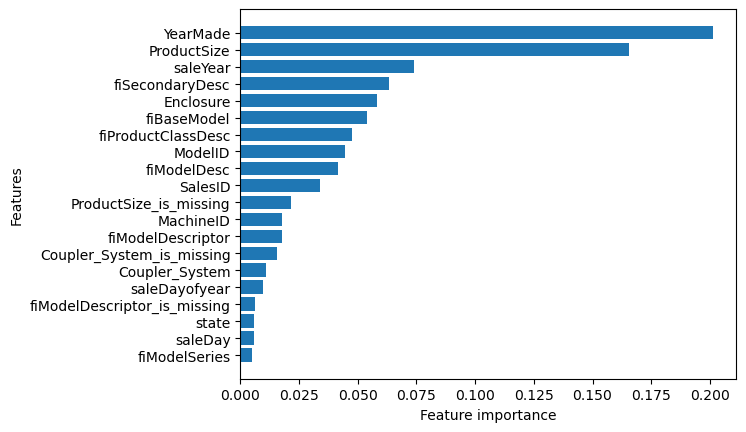

In [105]:
plot_features(X_train.columns, ideal_model.feature_importances_)

In [104]:
df.ProductSize.value_counts()

ProductSize
Medium            64342
Large / Medium    51297
Small             27057
Mini              25721
Large             21396
Compact            6280
Name: count, dtype: int64

In [101]:
df["Enclosure"].value_counts()

Enclosure
OROPS                  177971
EROPS                  141769
EROPS w AC              92601
EROPS AC                   18
NO ROPS                     3
None or Unspecified         2
Name: count, dtype: int64

In [102]:
df.Turbocharged.value_counts()

Turbocharged
None or Unspecified    77111
Yes                     3985
Name: count, dtype: int64

In [103]:
df.Thumb.value_counts()

Thumb
None or Unspecified    85074
Manual                  9678
Hydraulic               7580
Name: count, dtype: int64

Question to finish: Why might knowing the feature importances of a trained machine learning model be helpful?

Final challenge/extension: What other machine learning models could you try on our dataset? Hint: https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html check out the regression section of this map, or try to look at something like CatBoost.ai or XGBooost.ai.